## Compare Random Forest in the case of binary class (Sell, Buy)

In [47]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    backtest_strategy,
    display_report,
    objective_random_forest,
    plot_feature_imp,
    plot_strategy,
    select_threshold,
)

In [2]:
METRIC = "precision"
TEST_SIZE = 300
FPR_MAX = 0.01
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline Random Forest Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
# orig_df["r"] = interest_rate

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [11]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 19:40:46,003] A new study created in memory with name: no-name-5c5614c9-9c1b-4b4e-9d30-fca12ded8a5b


[I 2024-02-14 19:40:53,990] Trial 0 finished with value: 0.6950144107413505 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 192, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.6950144107413505.
[I 2024-02-14 19:41:02,751] Trial 1 finished with value: 0.6950144107413505 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 193, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.6950144107413505.
[I 2024-02-14 19:41:10,804] Trial 2 finished with value: 0.665533369936513 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 154, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6950144107413505.
[I 2024-02-14 19:41:12,202] Trial 3 finished with value: 0.5417590996912982 and parameters: {'max_features': 'log2', 'max_d

Number of finished trials: 114
Best trial:
  Value: 0.707377298567207
  Params: 
    max_features: log2
    max_depth: 18
    n_estimators: 122
    min_samples_split: 4
    min_samples_leaf: 1
    bootstrap: False
    criterion: gini


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=18,
                                        max_features='log2',
                                        min_samples_split=4, n_estimators=122,
                                        random_state=1968))])

In [14]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [15]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.65


In [16]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [17]:
pipe.score(X_test, y_test)

0.5

              precision    recall  f1-score   support

           0       0.60      0.36      0.45       170
           1       0.45      0.68      0.54       130

    accuracy                           0.50       300
   macro avg       0.53      0.52      0.50       300
weighted avg       0.54      0.50      0.49       300



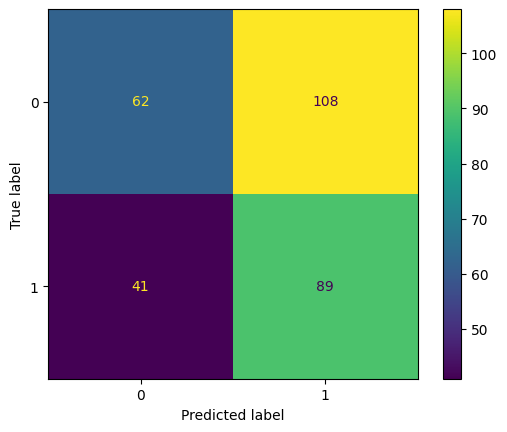

In [18]:
display_report(y_test, predictions)

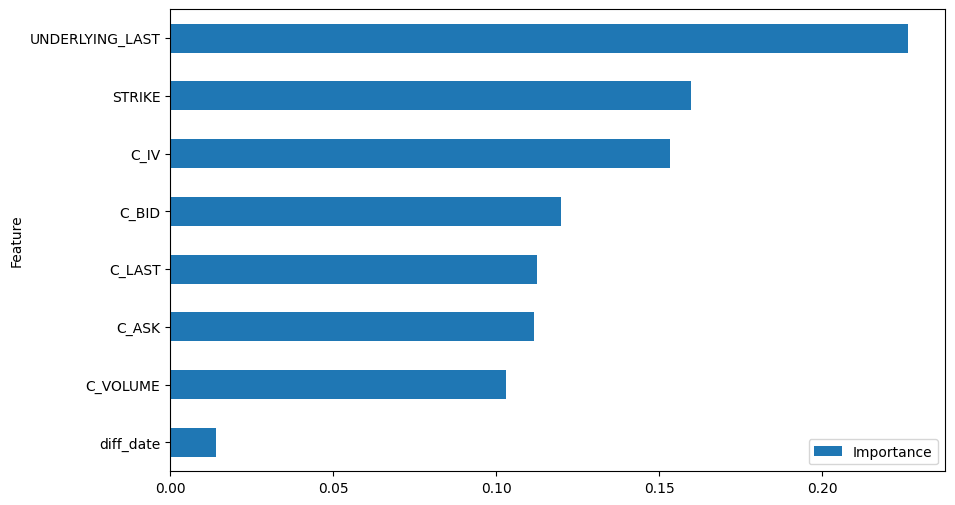

In [19]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [20]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [21]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [22]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.00,-7.580000,0.000000,-7.580000
2022-08-05,1,413.0,7.66,2022-08-26,405.309998,-7.66,-7.660000,-7.660000,-15.240000
2022-08-08,0,413.0,7.44,2022-08-29,402.630005,0.00,-7.440000,-7.660000,-22.680000
2022-08-09,1,411.0,7.51,2022-08-29,402.630005,-7.51,-7.510000,-15.170000,-30.190000
2022-08-10,1,420.0,6.90,2022-08-31,395.179993,-6.90,-6.900000,-22.070000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.00,-2.390007,115.390021,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,115.390021,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,115.390021,126.819912


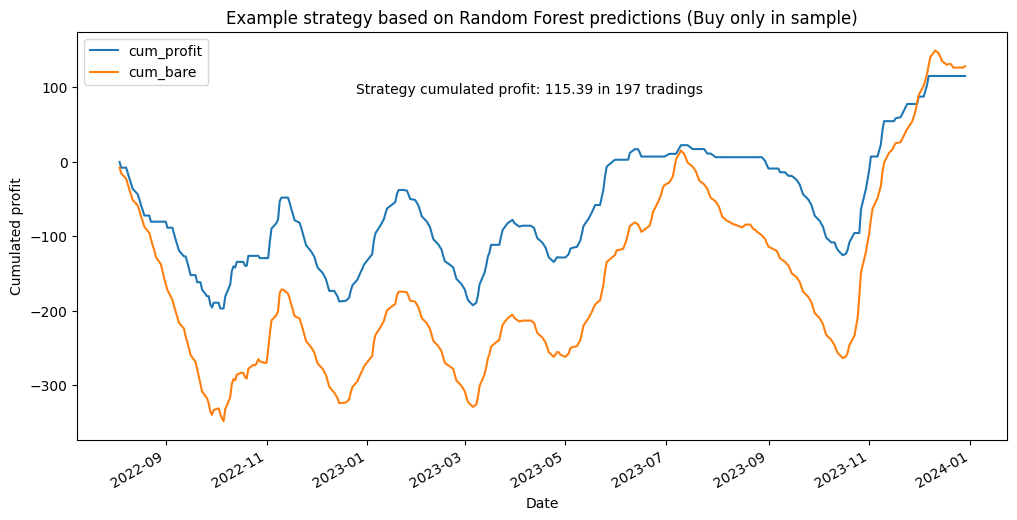

In [23]:
plot_strategy(strategy_df, "Random Forest", "(Buy only in sample)")

In [24]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## Random Forest with data from MC simulation and additional features

In [25]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [26]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [28]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=2048, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 19:50:50,320] A new study created in memory with name: no-name-cb66ff12-9666-4b23-8de7-671d3d5f7d79
[I 2024-02-14 19:51:01,041] Trial 0 finished with value: 0.7526645945059288 and parameters: {'max_features': 'sqrt', 'max_depth': 16, 'n_estimators': 141, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7526645945059288.
[I 2024-02-14 19:51:12,335] Trial 1 finished with value: 0.7519293412665399 and parameters: {'max_features': 'sqrt', 'max_depth': 17, 'n_estimators': 148, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7526645945059288.
[I 2024-02-14 19:51:18,414] Trial 2 finished with value: 0.7336363815821921 and parameters: {'max_features': 'sqrt', 'max_depth': 13, 'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7526645945059288

Number of finished trials: 150
Best trial:
  Value: 0.7731168653448018
  Params: 
    max_features: log2
    max_depth: 17
    n_estimators: 86
    min_samples_split: 2
    min_samples_leaf: 1
    bootstrap: True
    criterion: gini


In [29]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [30]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(max_depth=17, max_features='log2',
                                        n_estimators=86, random_state=1968))])

In [31]:
# In-sample score
pipe.score(X_train, y_train)

0.9991319444444444

In [32]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.58


In [33]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [34]:
pipe.score(X_test, y_test)

0.48333333333333334

              precision    recall  f1-score   support

           0       0.57      0.35      0.43       170
           1       0.44      0.66      0.53       130

    accuracy                           0.48       300
   macro avg       0.50      0.50      0.48       300
weighted avg       0.51      0.48      0.47       300



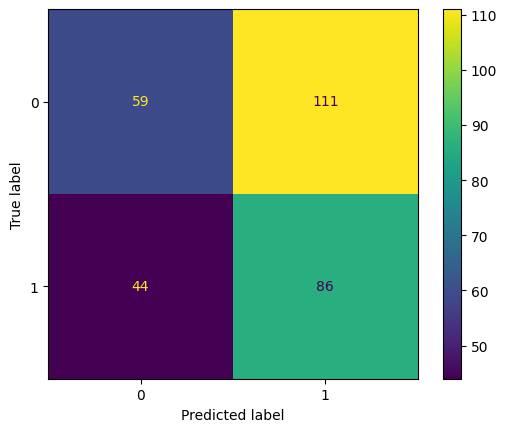

In [35]:
display_report(y_test, predictions)

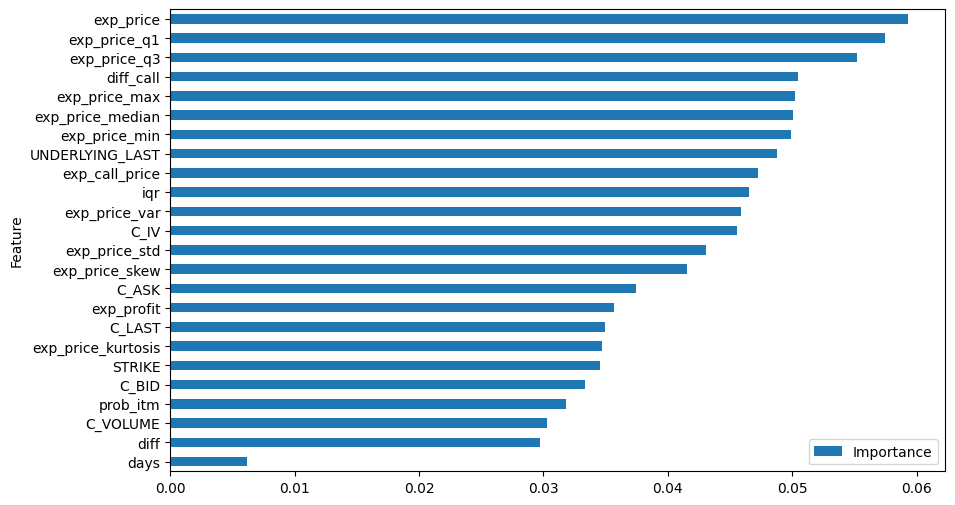

In [36]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [37]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [38]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [39]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.00,-7.580000,0.000000,-7.580000
2022-08-05,0,413.0,7.66,2022-08-26,405.309998,0.00,-7.660000,0.000000,-15.240000
2022-08-08,1,413.0,7.44,2022-08-29,402.630005,-7.44,-7.440000,-7.440000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.00,-7.510000,-7.440000,-30.190000
2022-08-10,0,420.0,6.90,2022-08-31,395.179993,0.00,-6.900000,-7.440000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.00,-2.390007,35.219941,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,35.219941,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,35.219941,126.819912


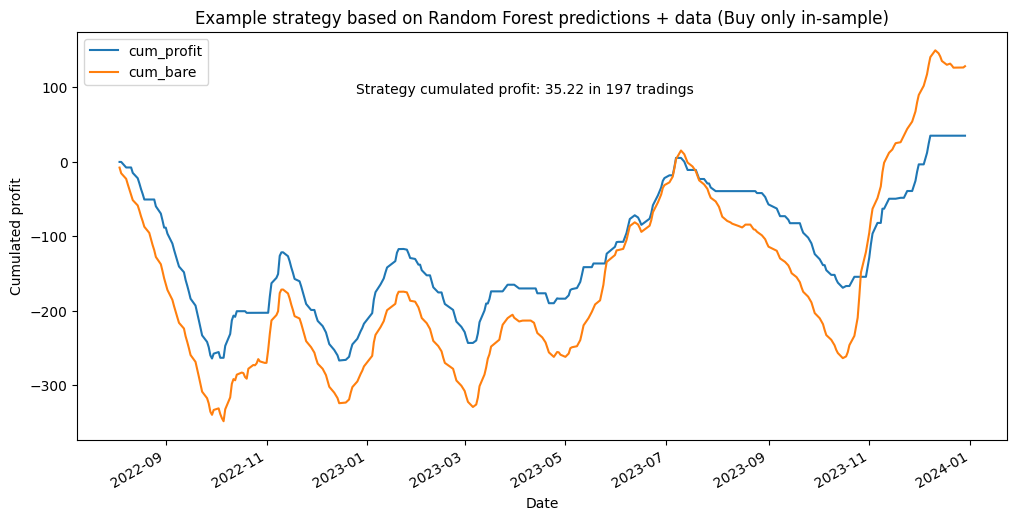

In [40]:
plot_strategy(strategy_df, "Random Forest", "+ data (Buy only in-sample)")

In [41]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [42]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)

In [43]:
compare_df[mask_in]

,bare_rf_pred_in,cum_profit_out,mmar_rf_pred_in,mmar_cum_profit_out,mmar_cum_bare_out
1,1,-7.660000,0,0.000000,-15.240000
2,0,-7.660000,1,-7.440000,-22.680000
3,1,-15.170000,0,-7.440000,-30.190000
4,1,-22.070000,0,-7.440000,-37.090000
5,1,-28.990000,0,-7.440000,-44.010000
...,...,...,...,...,...
277,1,58.670046,0,-49.420032,25.210004
279,1,68.720045,0,-48.150020,35.260002
282,0,77.830032,1,-25.360039,67.829969
283,0,77.830032,1,-13.090045,80.099963


In [44]:
compare_df[mask_in].shape

(90, 5)

In [45]:
compare_df.sum(axis=0)

bare_rf_pred_in          197.000000
cum_profit_out        -19008.706344
mmar_rf_pred_in          197.000000
mmar_cum_profit_out   -37252.034015
mmar_cum_bare_out     -49180.449390
dtype: float64

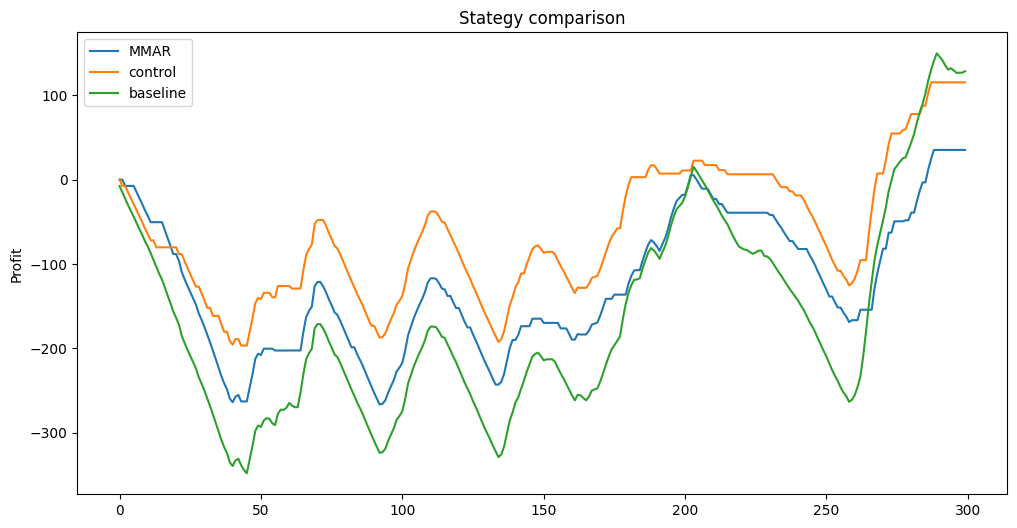

In [48]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()